## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import pickle
import os

from skimage.restoration import inpaint
from skimage.feature import canny
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ks_2samp, anderson_ksamp, wasserstein_distance
from scipy.stats import probplot


In [2]:
from azureml.core import Dataset, Workspace, Model

## Mount Dataset for visualization

In [3]:
workspace = Workspace.from_config()

In [4]:
#dataset = Dataset.get_by_name(workspace, name='RGBDS-464K', version=2)
dataset = Dataset.get_by_name(workspace, name='RGBDS-150K-test', version=2)
mount_ctx = dataset.mount()  
mount_ctx.start()
mount_path = mount_ctx.mount_point
print(mount_path)

Message: Running rslex direct volume mount: RSLEX_DIRECT_VOLUME_MOUNT=None, RSLEX_DIRECT_VOLUME_WRITABLE_MOUNT=None, enable_rslex_mount=None
Payload: {"pid": 21848, "version": "4.11.3"}


/tmp/tmp4x_5gn93


In [5]:
csv_file_path = "azureml/5e607a29-3421-4fc7-8e94-2077c4f576cb/score_output/results.csv" # mobilenetv1 filtered iqr
score_output_dataset = Dataset.Tabular.from_delimited_files(path=[(workspace.datastores['workspaceblobstore'], csv_file_path)])
df_results = score_output_dataset.to_pandas_dataframe()

In [6]:
df_results['error'] = df_results['predicted_height'] - df_results['height']
df_results = df_results[['depth_artifact_id', 'predicted_height', 'error']]

In [7]:
train_df = pd.read_csv(os.path.join(mount_path, 'labels.csv'))

In [8]:
train_df = pd.merge(train_df, df_results, on='depth_artifact_id', how='inner')

## Read csv

In [9]:
#train_df = pd.read_csv('labels_folder/train_labels.csv')
bad_data = pd.read_csv('data_bad.csv')
good_data = pd.read_csv('data_good.csv')

In [10]:
train_df["pose_data_2"] = train_df["pose_data"].apply(lambda x: eval(x)) # from str to dict
train_df["pose_score"] = train_df["pose_data_2"].apply(lambda x: float(x["Pose Scores"]))

In [12]:
train_df.columns


Index(['scan_id', 'scan_step', 'scan_version', 'height', 'weight', 'muac',
       'device_model', 'person_id', 'age', 'sex', 'depth_artifact_id',
       'rgb_artifact_id', 'depth_file_path', 'rgb_file_path', 'seg_file_path',
       'order_number', 'pose_data', 'no_of_person', 'bbox_coordinates',
       'bbox_coordinates_flat', 'device_pose', 'raw_header', 'angle',
       'distance_to_child', 'depthmap_validity', 'overlap', 'pickle_file_path',
       'predicted_height', 'error', 'pose_data_2', 'pose_score'],
      dtype='object')

In [11]:
bad_person_id_list = bad_data['person_id'].tolist()
good_person_id_list = good_data['person_id'].tolist()

In [6]:
bad_df = train_df[train_df['person_id'].isin(bad_person_id_list)]
good_df = train_df[train_df['person_id'].isin(good_person_id_list)]

In [7]:
train_df = train_df[(train_df['distance_to_child'] >= 1) & (train_df['distance_to_child'] <= 3)]

In [8]:
train_df = train_df.dropna()

## Analyze through df train vs bad vs good

In [9]:
summary_stats = train_df.describe()
print(summary_stats)

         scan_step       height       weight         muac          age  \
count  7068.000000  7068.000000  7068.000000  7068.000000  7068.000000   
mean    101.246746    95.443152    12.803275    14.276924  1432.707980   
std       4.003424     7.734488     2.090273     0.920392   320.138881   
min     100.000000    65.300000     6.150000    10.600000   268.000000   
25%     101.000000    90.100000    11.500000    13.600000  1219.000000   
50%     101.000000    95.600000    12.600000    14.200000  1504.000000   
75%     101.000000   100.800000    14.100000    14.800000  1714.000000   
max     202.000000   115.000000    19.600000    17.600000  1825.000000   

       order_number  no_of_person        angle  distance_to_child  \
count   7068.000000   7068.000000  7068.000000        7068.000000   
mean      12.258630      1.053480   -22.703035           1.103502   
std        8.317793      0.322669     9.833349           0.112102   
min        1.000000      1.000000   -76.652947           

In [10]:
summary_stats_bad = bad_df.describe()
print(summary_stats_bad)

         scan_step       height       weight         muac          age  \
count  1574.000000  1574.000000  1574.000000  1574.000000  1574.000000   
mean    101.105464    94.742186    12.444219    14.188310  1385.757306   
std       0.568562     7.388497     1.848217     0.936681   311.705114   
min     100.000000    74.300000     8.250000    12.700000   487.000000   
25%     101.000000    89.300000    11.150000    13.400000  1183.000000   
50%     101.000000    95.000000    12.450000    14.100000  1472.000000   
75%     101.000000   101.800000    14.250000    14.800000  1631.250000   
max     102.000000   106.500000    15.100000    16.400000  1825.000000   

       order_number  no_of_person        angle  distance_to_child  \
count   1574.000000   1574.000000  1574.000000        1574.000000   
mean      10.741423      1.037484   -30.266011           0.636490   
std        7.606074      0.232169     8.772030           0.132175   
min        1.000000      1.000000   -49.776282           

In [11]:
summary_stats_good = good_df.describe()
print(summary_stats_good)

         scan_step       height       weight         muac          age  \
count  2622.000000  2622.000000  2622.000000  2622.000000  2622.000000   
mean    101.107933    87.525553    11.189836    13.898207  1094.372616   
std       0.549862     9.024144     2.257611     0.936146   404.312315   
min     100.000000    71.400000     7.100000    12.100000   360.000000   
25%     101.000000    79.800000     9.600000    13.200000   791.000000   
50%     101.000000    88.000000    11.350000    13.800000  1155.000000   
75%     101.000000    94.200000    12.600000    14.500000  1389.000000   
max     102.000000   109.700000    16.850000    16.600000  1787.000000   

       order_number  no_of_person        angle  distance_to_child  \
count   2622.000000   2622.000000  2622.000000        2622.000000   
mean      12.131198      1.143402   -37.086371           0.565318   
std       10.318707      0.574174    10.643877           0.203527   
min        1.000000      1.000000   -72.177866           

In [12]:
summary_stats.columns = [f'{col}_original' for col in summary_stats.columns]
summary_stats_bad.columns = [f'{col}_bad' for col in summary_stats_bad.columns]
summary_stats_good.columns = [f'{col}_good' for col in summary_stats_good.columns]

comparison_summary = pd.concat([summary_stats, summary_stats_bad, summary_stats_good], axis=1)
comparison_summary = comparison_summary.reindex(sorted(comparison_summary.columns), axis=1)

print("Comparison of Summary Statistics:")
print(comparison_summary)

Comparison of Summary Statistics:
           age_bad     age_good  age_original    angle_bad   angle_good  \
count  1574.000000  2622.000000   7068.000000  1574.000000  2622.000000   
mean   1385.757306  1094.372616   1432.707980   -30.266011   -37.086371   
std     311.705114   404.312315    320.138881     8.772030    10.643877   
min     487.000000   360.000000    268.000000   -49.776282   -72.177866   
25%    1183.000000   791.000000   1219.000000   -37.129107   -43.849705   
50%    1472.000000  1155.000000   1504.000000   -32.120351   -37.304178   
75%    1631.250000  1389.000000   1714.000000   -24.151631   -31.433386   
max    1825.000000  1787.000000   1825.000000    -9.445385    -3.542104   

       angle_original  depthmap_validity_bad  depthmap_validity_good  \
count     7068.000000            1574.000000             2622.000000   
mean       -22.703035               0.866038                0.868209   
std          9.833349               0.039234                0.054496   
mi

In [13]:
def compare_distributions(train, bad, good, column_name):
    """
    Compare distributions of a specified column between three DataFrames: train, bad, and good.

    Parameters:
    - train: Train DataFrame
    - bad: Bad DataFrame
    - good: Good DataFrame
    - column_name: Column to compare

    Prints and displays various statistical tests and visualizations.

    """

    # Histograms
    plt.hist(train[column_name], bins=10, alpha=0.5, label='Train', edgecolor='black')
    plt.hist(bad[column_name], bins=10, alpha=0.5, label='Bad', edgecolor='black')
    plt.hist(good[column_name], bins=10, alpha=0.5, label='Good', edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {column_name} Distributions')
    plt.legend()
    plt.show()

    # Statistical tests
    ks_statistic_train_bad, ks_p_value_train_bad = ks_2samp(train[column_name], bad[column_name])
    ks_statistic_train_good, ks_p_value_train_good = ks_2samp(train[column_name], good[column_name])
    ks_statistic_bad_good, ks_p_value_bad_good = ks_2samp(bad[column_name], good[column_name])
    
    ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
    ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
    ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])

    emd_distance_train_bad = wasserstein_distance(train[column_name], bad[column_name])
    emd_distance_train_good = wasserstein_distance(train[column_name], good[column_name])
    emd_distance_bad_good = wasserstein_distance(bad[column_name], good[column_name])

    # Kolmogorov-Smirnov Test
    print("Kolmogorov-Smirnov Test:")
    print(f"  Train vs. Bad: Statistic: {ks_statistic_train_bad}, P-value: {ks_p_value_train_bad}")
    print(f"  Train vs. Good: Statistic: {ks_statistic_train_good}, P-value: {ks_p_value_train_good}")
    print(f"  Bad vs. Good: Statistic: {ks_statistic_bad_good}, P-value: {ks_p_value_bad_good}\n")

    # Anderson-Darling Test
    print("Anderson-Darling Test:")
    print(f"  Train vs. Bad: Statistic: {ad_statistic_train_bad}")
    print(f"  Train vs. Good: Statistic: {ad_statistic_train_good}")
    print(f"  Bad vs. Good: Statistic: {ad_statistic_bad_good}\n")

    # Wasserstein Distance (EMD)
    print(f"Wasserstein Distance (EMD):")
    print(f"  Train vs. Bad: {emd_distance_train_bad}")
    print(f"  Train vs. Good: {emd_distance_train_good}")
    print(f"  Bad vs. Good: {emd_distance_bad_good}\n")

    # Additional statistical analysis
    quartiles_train = np.percentile(train[column_name], [25, 50, 75])
    quartiles_bad = np.percentile(bad[column_name], [25, 50, 75])
    quartiles_good = np.percentile(good[column_name], [25, 50, 75])

    print("Statistical Analysis and Interpretation:")
    print(f"{'':<10} {'Train':<20} {'Bad':<20} {'Good':<20}")
    print(f"{'-'*70}")
    print(f"{'Q25':<10} {quartiles_train[0]:<20.2f} {quartiles_bad[0]:<20.2f} {quartiles_good[0]:<20.2f}")
    print(f"{'Q50':<10} {quartiles_train[1]:<20.2f} {quartiles_bad[1]:<20.2f} {quartiles_good[1]:<20.2f}")
    print(f"{'Q75':<10} {quartiles_train[2]:<20.2f} {quartiles_bad[2]:<20.2f} {quartiles_good[2]:<20.2f}")
    print(f"{'Mean':<10} {train[column_name].mean():<20.2f} {bad[column_name].mean():<20.2f} {good[column_name].mean():<20.2f}")
    print(f"{'Median':<10} {train[column_name].median():<20.2f} {bad[column_name].median():<20.2f} {good[column_name].median():<20.2f}")
    print(f"{'Std Deviation':<10} {train[column_name].std():<20.2f} {bad[column_name].std():<20.2f} {good[column_name].std():<20.2f}")
    print(f"{'Variance':<10} {train[column_name].var():<20.2f} {bad[column_name].var():<20.2f} {good[column_name].var():<20.2f}")
    print(f"{'Skewness':<10} {train[column_name].skew():<20.2f} {bad[column_name].skew():<20.2f} {good[column_name].skew():<20.2f}")
    print(f"{'Kurtosis':<10} {train[column_name].kurtosis():<20.2f} {bad[column_name].kurtosis():<20.2f} {good[column_name].kurtosis():<20.2f}\n")

    # Visual inspections
    probplot(train[column_name], plot=plt)
    plt.title(f'Q-Q Plot - {column_name} - Train')
    plt.show()

    probplot(bad[column_name], plot=plt)
    plt.title(f'Q-Q Plot - {column_name} - Bad')
    plt.show() 

    probplot(good[column_name], plot=plt)
    plt.title(f'Q-Q Plot - {column_name} - Good')
    plt.show()


Compare angle distributions


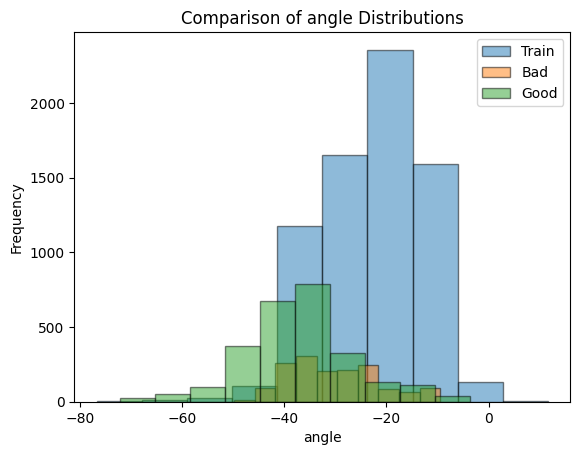

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.36716676410458865, P-value: 2.313298562696012e-155
  Train vs. Good: Statistic: 0.5508476661499471, P-value: 4.224e-321
  Bad vs. Good: Statistic: 0.2743829215600185, P-value: 1.150909886359646e-65

Anderson-Darling Test:
  Train vs. Bad: Statistic: 511.14652787087886
  Train vs. Good: Statistic: 1870.6664447752448
  Bad vs. Good: Statistic: 300.66669698496366

Wasserstein Distance (EMD):
  Train vs. Bad: 7.732293804639802
  Train vs. Good: 14.385867948265819
  Bad vs. Good: 6.914335690289695

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        -30.34               -37.13               -43.85              
Q50        -21.05               -32.12               -37.30              
Q75        -14.98               -24.15               -31.43              
Mean       -22.70               -30.27

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


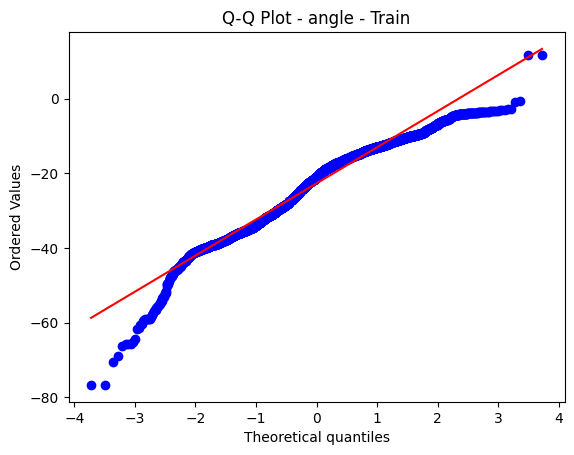

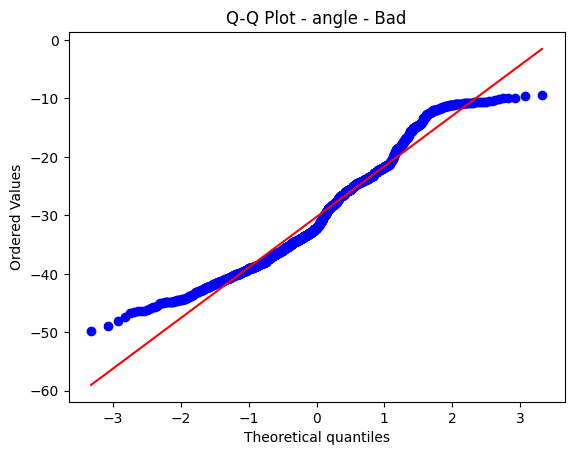

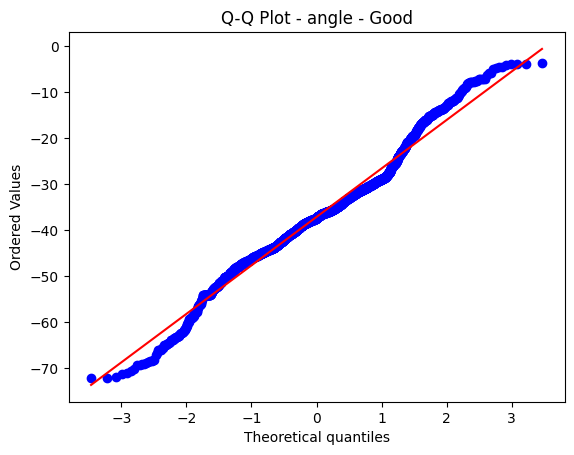

In [14]:
print("Compare angle distributions")
compare_distributions(train_df, bad_df, good_df, 'angle')

Compare distance_to_child distributions


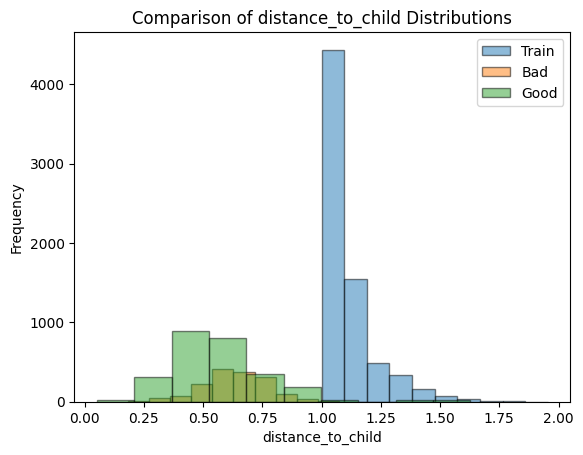

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.9974587039390089, P-value: 0.0
  Train vs. Good: Statistic: 0.9774980930587338, P-value: 0.0
  Bad vs. Good: Statistic: 0.2955647502270399, P-value: 2.689888929684553e-76

Anderson-Darling Test:
  Train vs. Bad: Statistic: 3211.3609910950263
  Train vs. Good: Statistic: 4082.1583007901686
  Bad vs. Good: Statistic: 225.54230353659648

Wasserstein Distance (EMD):
  Train vs. Bad: 0.46701186297711317
  Train vs. Good: 0.5381836199896657
  Bad vs. Good: 0.09721513544371398

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        1.03                 0.56                 0.42                
Q50        1.07                 0.64                 0.54                
Q75        1.13                 0.73                 0.67                
Mean       1.10                 0.64                 0.57    

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


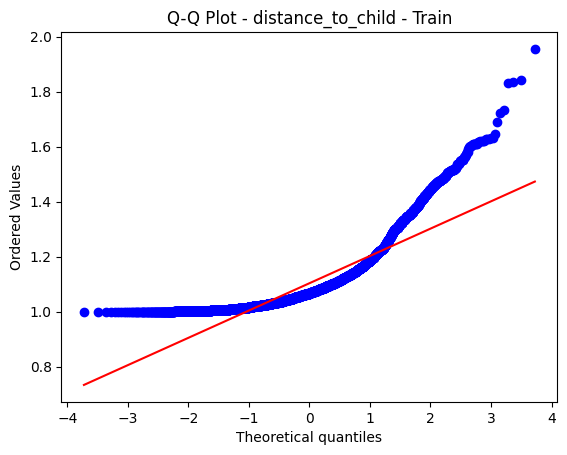

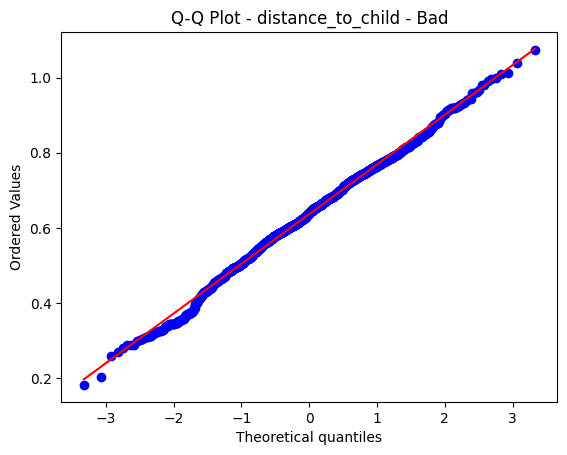

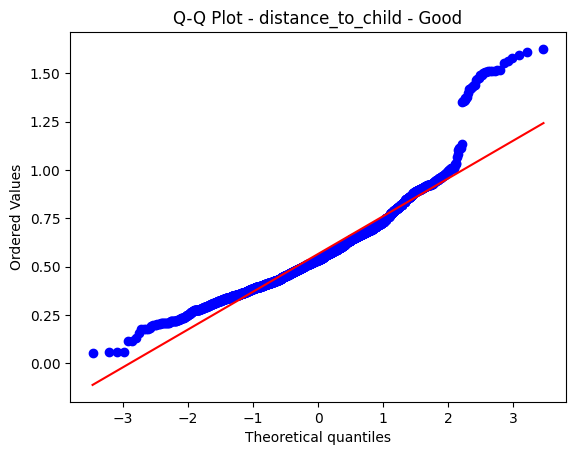

In [15]:
print("Compare distance_to_child distributions")
compare_distributions(train_df, bad_df, good_df, 'distance_to_child')

Compare pose_score distributions


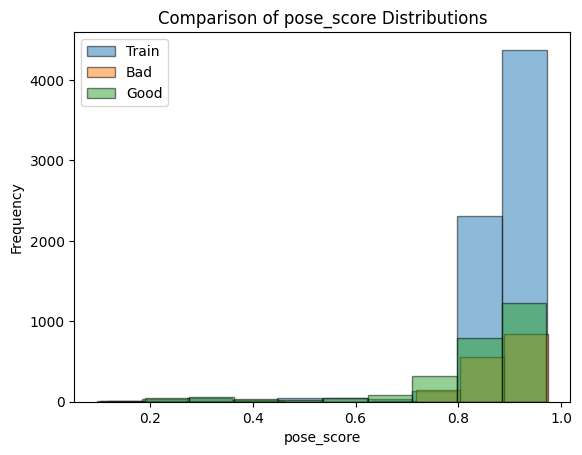

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.08758626492040653, P-value: 4.817809093969849e-09
  Train vs. Good: Statistic: 0.2150230063236633, P-value: 6.094872574495417e-78
  Bad vs. Good: Statistic: 0.15020542627769912, P-value: 8.027099940003308e-20

Anderson-Darling Test:
  Train vs. Bad: Statistic: 28.24044480039899
  Train vs. Good: Statistic: 300.70464176519926
  Bad vs. Good: Statistic: 76.99609120177843

Wasserstein Distance (EMD):
  Train vs. Bad: 0.015576980710154014
  Train vs. Good: 0.053134963419948986
  Bad vs. Good: 0.04841258019948849

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        0.86                 0.84                 0.81                
Q50        0.91                 0.89                 0.88                
Q75        0.94                 0.94                 0.93                
Mean       0.89       

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


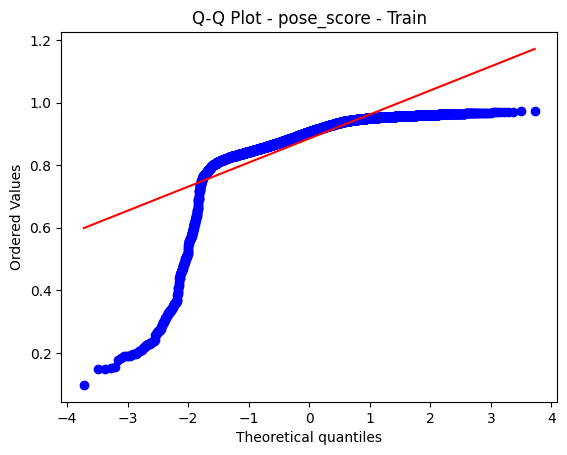

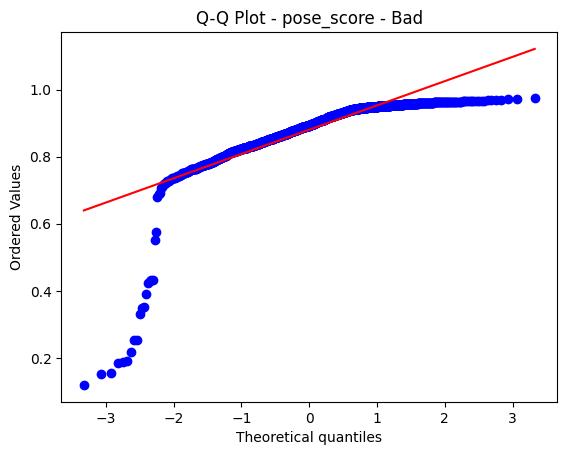

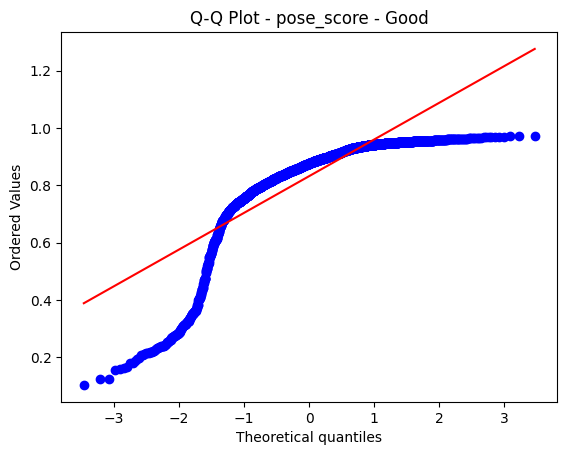

In [16]:
print("Compare pose_score distributions")
compare_distributions(train_df, bad_df, good_df, 'pose_score')

Compare overlap distributions


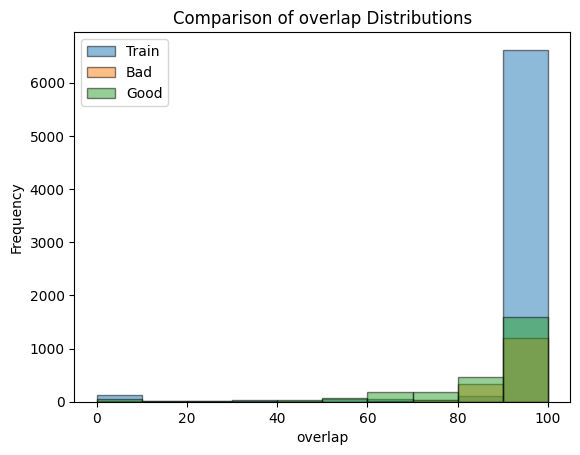

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.5075050570641055, P-value: 1.6113142431754905e-304
  Train vs. Good: Statistic: 0.4674466671587805, P-value: 5.795e-321
  Bad vs. Good: Statistic: 0.1913866346436225, P-value: 5.676773005997466e-32

Anderson-Darling Test:
  Train vs. Bad: Statistic: 1868.2192656524223
  Train vs. Good: Statistic: 2229.742121474242
  Bad vs. Good: Statistic: 85.34320696579525

Wasserstein Distance (EMD):
  Train vs. Bad: 5.912398592618347
  Train vs. Good: 8.885403777559112
  Bad vs. Good: 6.473455194524281

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        100.00               90.14                83.76               
Q50        100.00               95.41                93.39               
Q75        100.00               100.00               100.00              
Mean       96.00                93.53    

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


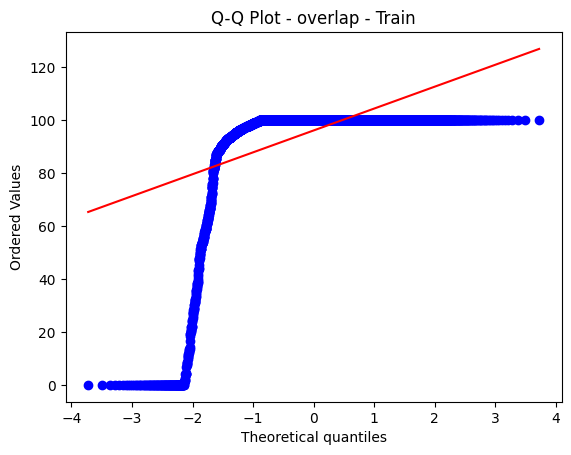

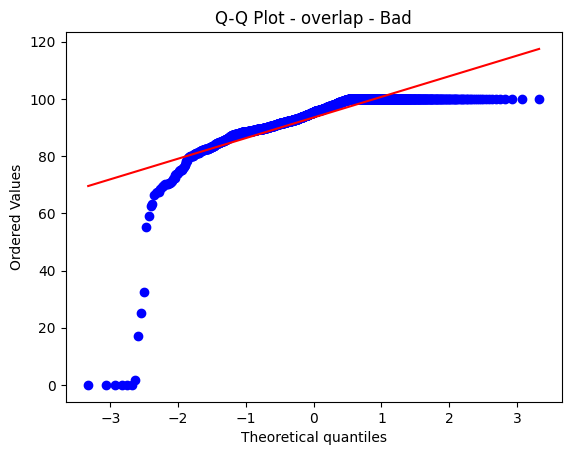

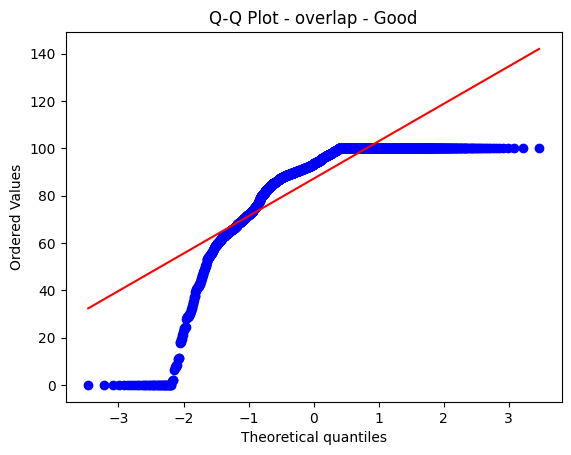

In [17]:
print("Compare overlap distributions")
compare_distributions(train_df, bad_df, good_df, 'overlap')


Compare age distributions


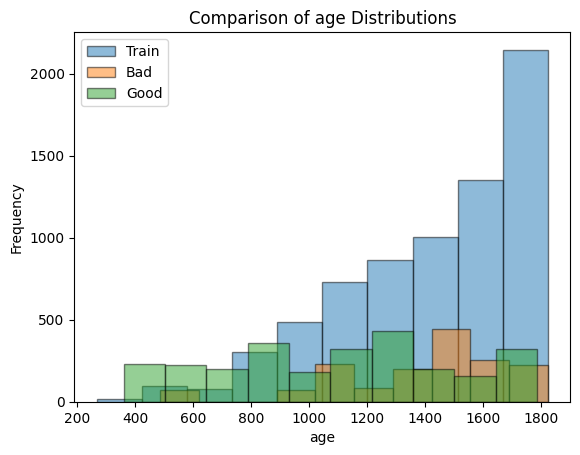

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.156555774401368, P-value: 5.236811939308916e-28
  Train vs. Good: Statistic: 0.3844578135380527, P-value: 5.4851324933837e-253
  Bad vs. Good: Statistic: 0.4110434918299561, P-value: 2.2034142434052262e-149

Anderson-Darling Test:
  Train vs. Bad: Statistic: 52.15727973833306
  Train vs. Good: Statistic: 931.2179350093039
  Bad vs. Good: Statistic: 385.41383638354114

Wasserstein Distance (EMD):
  Train vs. Bad: 57.245985809299256
  Train vs. Good: 338.3916734332325
  Bad vs. Good: 291.3846899027581

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        1219.00              1183.00              791.00              
Q50        1504.00              1472.00              1155.00             
Q75        1714.00              1631.25              1389.00             
Mean       1432.71             

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


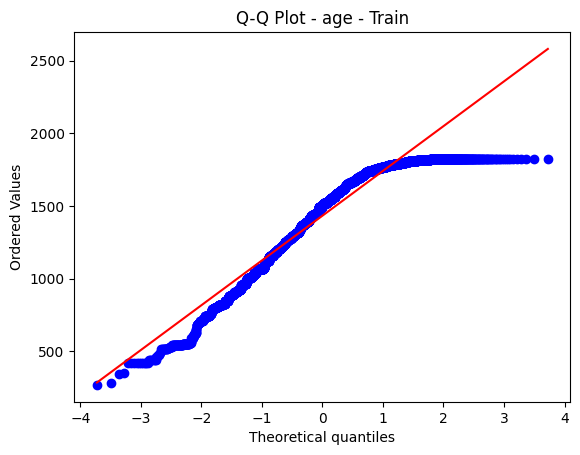

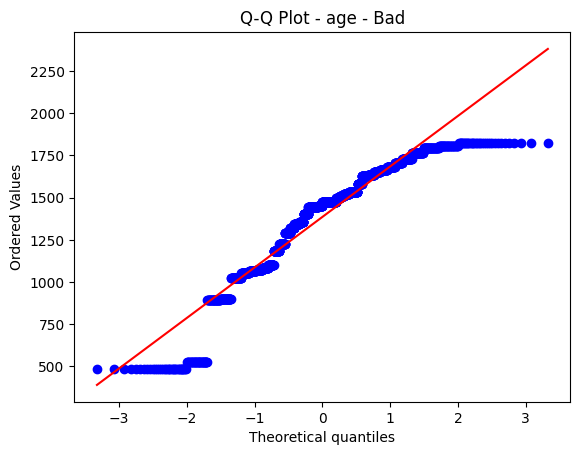

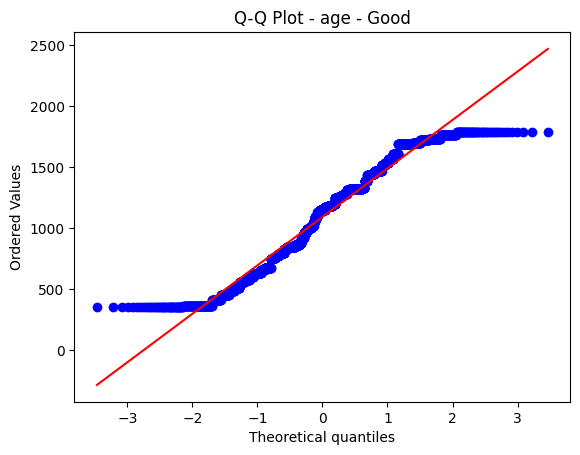

In [18]:
print("Compare age distributions")
compare_distributions(train_df, bad_df, good_df, 'age')

Compare height distributions


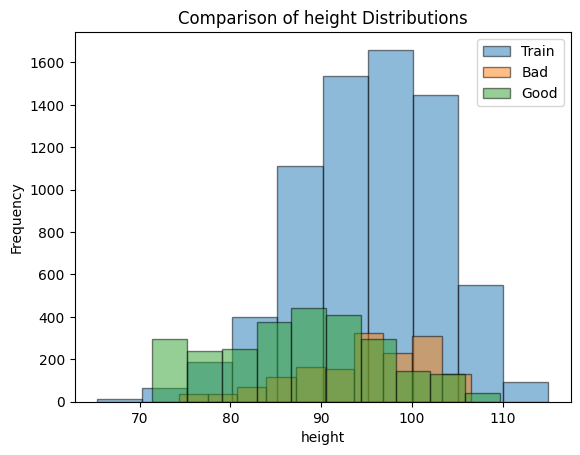

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.10202199867829594, P-value: 4.049673197242316e-12
  Train vs. Good: Statistic: 0.37837405575650207, P-value: 7.797838709193179e-245
  Bad vs. Good: Statistic: 0.38695254793522116, P-value: 6.332644443811558e-132

Anderson-Darling Test:
  Train vs. Bad: Statistic: 17.97746307073379
  Train vs. Good: Statistic: 970.3832758165566
  Bad vs. Good: Statistic: 439.74432775373833

Wasserstein Distance (EMD):
  Train vs. Bad: 0.9658983812361162
  Train vs. Good: 7.931549420535911
  Bad vs. Good: 7.316708779295899

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        90.10                89.30                79.80               
Q50        95.60                95.00                88.00               
Q75        100.80               101.80               94.20               
Mean       95.44          

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


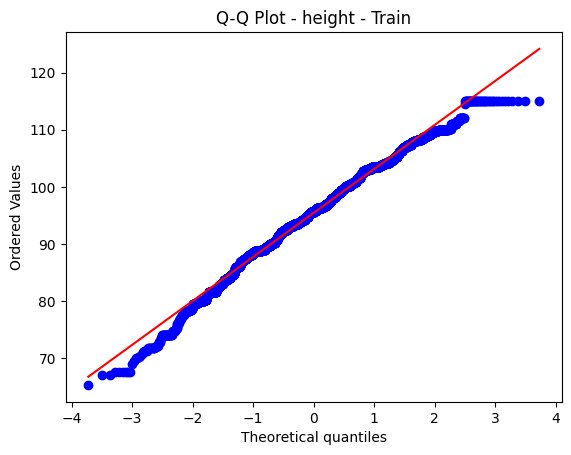

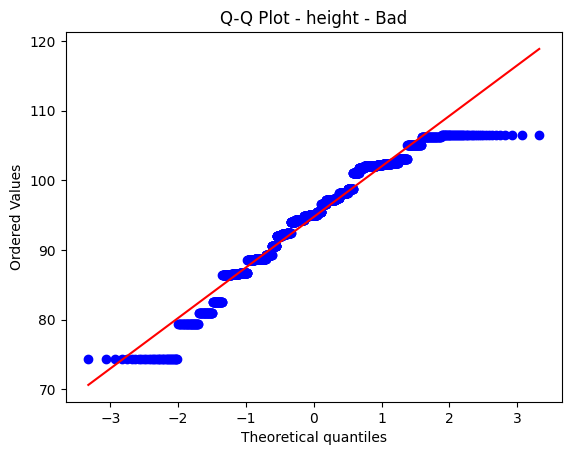

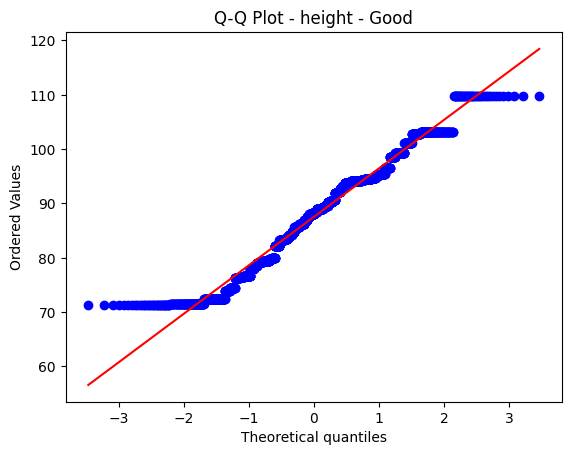

In [19]:
print("Compare height distributions")
compare_distributions(train_df, bad_df, good_df, 'height')

Compare weight distributions


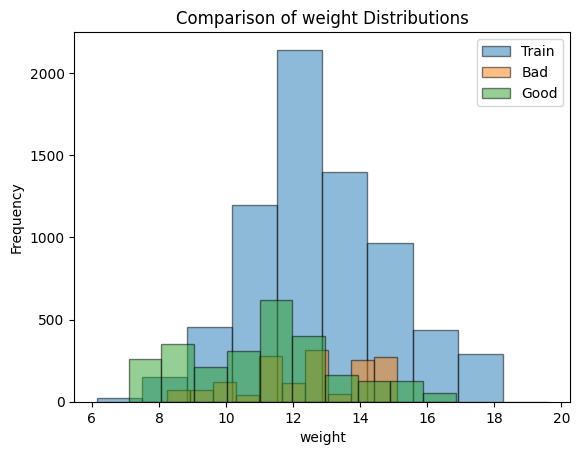

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.13483305036785512, P-value: 7.257072439774596e-21
  Train vs. Good: Statistic: 0.33892497723973325, P-value: 1.8613643093647814e-195
  Bad vs. Good: Statistic: 0.3015196407681266, P-value: 1.9200418060404193e-79

Anderson-Darling Test:
  Train vs. Bad: Statistic: 34.901427691557465
  Train vs. Good: Statistic: 680.2460214501833
  Bad vs. Good: Statistic: 249.75805201598956

Wasserstein Distance (EMD):
  Train vs. Bad: 0.43441900212062307
  Train vs. Good: 1.6150239290371795
  Bad vs. Good: 1.3768283859474664

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        11.50                11.15                9.60                
Q50        12.60                12.45                11.35               
Q75        14.10                14.25                12.60               
Mean       12.80      

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


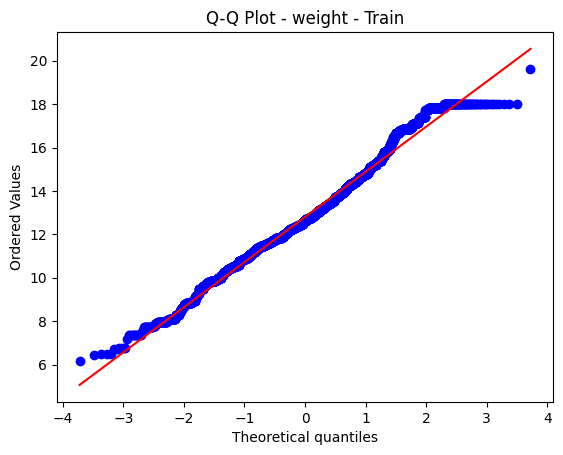

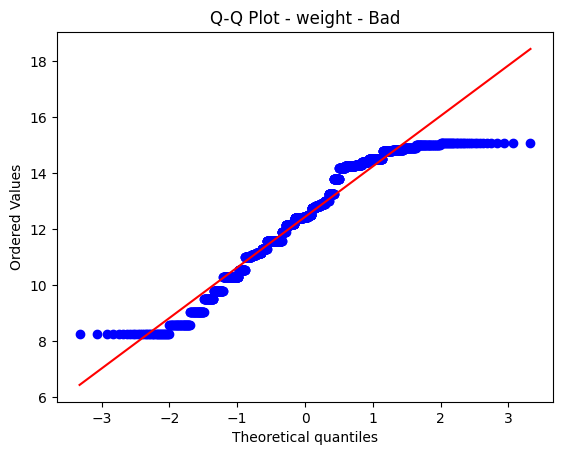

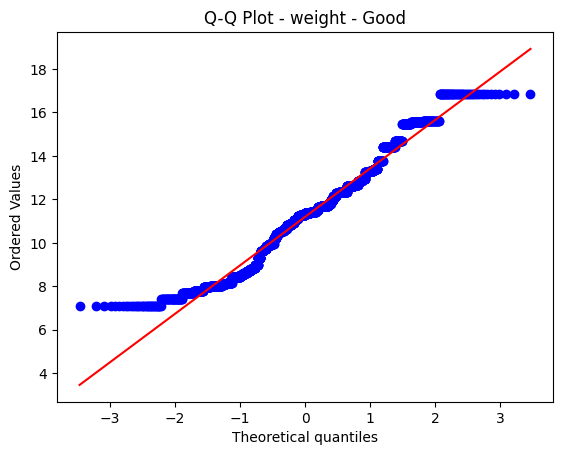

In [20]:
print("Compare weight distributions")
compare_distributions(train_df, bad_df, good_df, 'weight')

Compare muac distributions


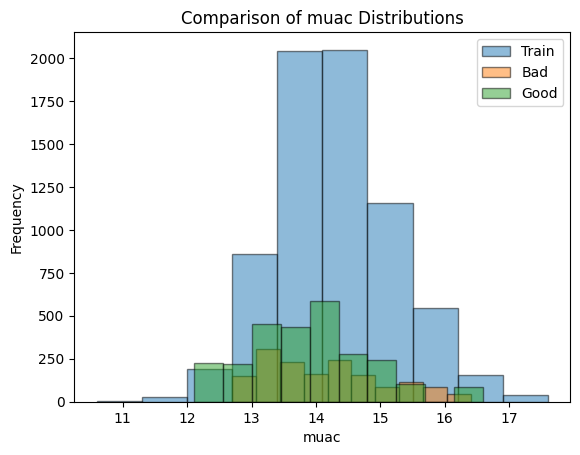

Kolmogorov-Smirnov Test:
  Train vs. Bad: Statistic: 0.11992846402599111, P-value: 1.3716622125866737e-16
  Train vs. Good: Statistic: 0.1924042223370488, P-value: 2.154380441559373e-62
  Bad vs. Good: Statistic: 0.1932557763116703, P-value: 1.3401798897467242e-32

Anderson-Darling Test:
  Train vs. Bad: Statistic: 25.404712946684274
  Train vs. Good: Statistic: 234.11264905589246
  Bad vs. Good: Statistic: 73.04909250190028

Wasserstein Distance (EMD):
  Train vs. Bad: 0.13791487521114543
  Train vs. Good: 0.387767894490785
  Bad vs. Good: 0.3006911026530473

Statistical Analysis and Interpretation:
           Train                Bad                  Good                
----------------------------------------------------------------------
Q25        13.60                13.40                13.20               
Q50        14.20                14.10                13.80               
Q75        14.80                14.80                14.50               
Mean       14.28         

/tmp/ipykernel_44479/3064913062.py:30: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_bad, _, _ = anderson_ksamp([train[column_name], bad[column_name]])
/tmp/ipykernel_44479/3064913062.py:31: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_train_good, _, _ = anderson_ksamp([train[column_name], good[column_name]])
/tmp/ipykernel_44479/3064913062.py:32: UserWarning: p-value floored: true value smaller than 0.001
  ad_statistic_bad_good, _, _ = anderson_ksamp([bad[column_name], good[column_name]])


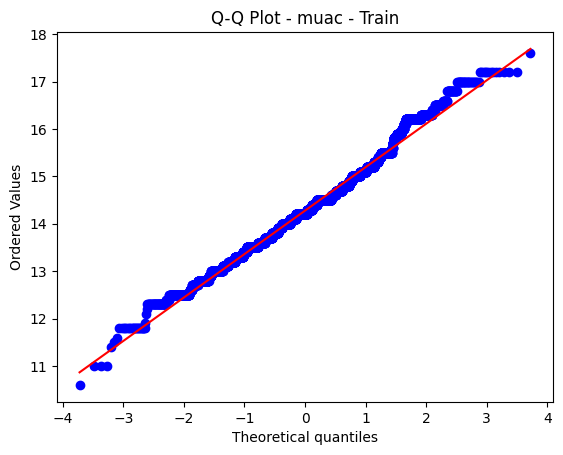

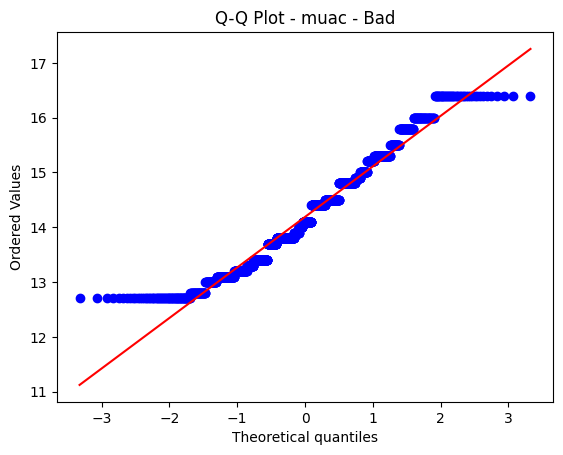

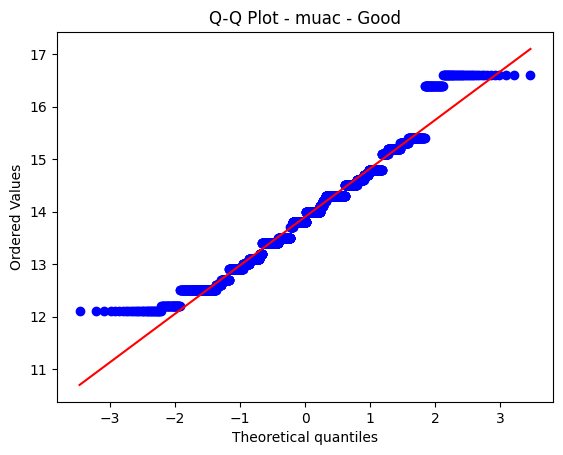

In [21]:
print("Compare muac distributions")
compare_distributions(train_df, bad_df, good_df, 'muac')

## Display all artifacts of a child

In [20]:
def preprocess_depthmap(depth_map):
    """
    Preprocess depth map by replacing values above 3 with 0 and then filling the 0 values.
    
    Args:
    - depth_map (numpy.ndarray): Depth map array.
    
    Returns:
    - depth_map_preprocessed (numpy.ndarray): Preprocessed depth map array.
    """
    # Replace values above 3 with 0
    depth_map[depth_map > 3] = 0
    
    # Fill 0 values using inpaint_biharmonic
    mask = (depth_map == 0)
    depth_map_filled = inpaint.inpaint_biharmonic(depth_map, mask=mask)
    
    return depth_map_filled

In [21]:
def preprocess_depth_figures(depth_figures):
    """
    Preprocess depth figures by replacing values above 3 with 0 and then filling the 0 values.
    
    Args:
    - depth_figures (list): List of tuples containing (depth image, title).
    
    Returns:
    - preprocessed_depth_figures (list): List of tuples containing preprocessed (depth image, title).
    """
    preprocessed_depth_figures = []
    
    for img_depth, title_depth in depth_figures:
        img_depth_preprocessed = preprocess_depthmap(img_depth.copy())
        preprocessed_depth_figures.append((img_depth_preprocessed, title_depth))
    
    return preprocessed_depth_figures

In [22]:
def calculate_edge_alignment_score(rgb_edges, depth_edges):
    # Ensure both edge maps are binary (0 or 1)
    rgb_edges = (rgb_edges > 0).astype(int)
    depth_edges = (depth_edges > 0).astype(int)

    # Calculate overlap
    overlap = np.sum((rgb_edges == 1) & (depth_edges == 1))
    total_edges = np.sum(rgb_edges)

    # Edge Alignment Score
    score = overlap / total_edges if total_edges > 0 else 0
    return score

In [23]:
def calculate_depth_consistency_score(depthmap_data):
    # Apply Gaussian blur
    smoothed_depthmap = gaussian_filter(depthmap_data, sigma=1)

    # Calculate the difference
    difference = np.abs(depthmap_data - smoothed_depthmap)

    # Depth Consistency Score (Inverse of average difference)
    score = 1 - np.mean(difference)
    return score

In [24]:
def calculate_histogram_analysis_score(depthmap_data):
    # Compute histogram
    hist, _ = np.histogram(depthmap_data, bins=50)

    # Calculate standard deviation of the histogram
    std_dev = np.std(hist)

    # Histogram Analysis Score (Inverse of standard deviation)
    score = 1 / (1 + std_dev)  # To normalize and avoid division by zero
    return score

In [25]:
# Define the custom colormap
colors = [
    (0, 0, 0),    # Black
    (1, 0, 0),    # Red
    (1, 1, 0),    # Yellow
    (0, 1, 0),    # Green
    (0, 0, 1),    # Blue
    (1, 0, 1),    # Magenta
    (0, 1, 1)     # Cyan
]
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

In [26]:
def calculate_coverage_and_depth_stats(depth_map, segment_map):
    """
    Calculate the coverage score indicating how much of the child covers the image,
    and return statistics including the average depth value (including and excluding zeros),
    minimum non-zero depth value, and maximum depth value within the child region.

    Args:
    depth_map (numpy.ndarray): NumPy array representing the depth map.
    segment_map (numpy.ndarray): NumPy array representing the segment map.

    Returns:
    tuple: A tuple containing the coverage score as a fraction of the image, 
           the average depth value within the child (including zeros),
           the average depth value within the child (excluding zeros),
           the minimum non-zero depth value, and the maximum depth value.
    """
    # Assuming the child is represented by non-zero values in the segment map
    child_mask = segment_map > 0

    # Find depth values within the child region
    depth_values_within_child = depth_map[child_mask]

    # Calculate the coverage score
    child_pixels = np.sum(child_mask)
    total_pixels = depth_map.size
    coverage_score = child_pixels / total_pixels

    # Calculate the average depth value within the child (including zeros)
    average_depth_with_zeros = np.mean(depth_values_within_child)

    # Calculate the average depth value within the child (excluding zeros)
    average_depth_without_zeros = np.mean(depth_values_within_child[depth_values_within_child != 0])

    # Calculate the minimum non-zero depth value within the child
    min_depth_non_zero = np.min(depth_values_within_child[depth_values_within_child != 0])

    # Calculate the maximum depth value within the child
    max_depth = np.max(depth_values_within_child)

    return coverage_score, average_depth_with_zeros, average_depth_without_zeros, min_depth_non_zero, max_depth

In [27]:
def calculate_contrast(depth_map):
    """
    Calculate various contrast measures for a depth map.

    Args:
    depth_map (numpy.ndarray): NumPy array representing the depth map.

    Returns:
    float: Standard Deviation of the depth map.
    float: Dynamic Range of the depth map.
    float: Michelson Contrast of the depth map.
    """
    max_intensity = np.max(depth_map)
    min_intensity = np.min(depth_map)
    std_deviation = np.std(depth_map)
    dynamic_range = max_intensity - min_intensity
    michelson_contrast = (max_intensity - min_intensity) / (max_intensity + min_intensity)

    return std_deviation, dynamic_range, michelson_contrast

In [28]:
def statistical_analysis(depth_map):
    """
    Perform statistical analysis on the depth map.

    Args:
        depth_map (numpy.ndarray): NumPy array representing the depth map.

    Returns:
        float: Skewness
        float: Kurtosis
    """
    skewness = stats.skew(depth_map.flatten())
    kurtosis = stats.kurtosis(depth_map.flatten())

    return skewness, kurtosis

In [29]:
def display_images(depthmap_data, rgb_data, segmap_data, rgb_edges, custom_cmap):
    fig = plt.figure(figsize=(48, 6))  # Adjusted for an additional image

    # Display depthmap, RGB, and segmap images
    ax1 = fig.add_subplot(1, 7, 1)
    ax1.imshow(depthmap_data,  cmap='jet', vmin=0, vmax=3)  # Assuming depthmap_data is a 2D array
    ax1.set_title('Depthmap Image')
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 7, 2)
    ax2.imshow(rgb_data)
    ax2.set_title('RGB Image')
    ax2.axis('off')

    ax3 = fig.add_subplot(1, 7, 3)
    ax3.imshow(segmap_data, cmap='gray')  # Assuming segmap_data is a 2D array
    ax3.set_title('Segmap Image')
    ax3.axis('off')

    # Apply segmentation by masking the depth map with the segmentation map
    segmented_depthmap = np.where(segmap_data > 0, depthmap_data, np.nan)  # Use np.nan to mask non-segmented regions

    # Display the segmented depthmap using Matplotlib
    ax4 = fig.add_subplot(1, 7, 4)
    ax4.imshow(segmented_depthmap, cmap='gray')  # You can choose a different colormap
    ax4.set_title('Segmented Depthmap')
    ax4.axis('off')

    # Display colored depthmap image with color bar
    ax5 = fig.add_subplot(1, 7, 5)
    img = ax5.imshow(depthmap_data, cmap=custom_cmap)  # Assuming depthmap_data is a 2D array
    ax5.set_title('Colored Depthmap Image')
    ax5.axis('off')
    
    # Add a color bar to the 'Colored Depthmap Image' subplot
    cbar = plt.colorbar(img, ax=ax5, shrink=0.95)  # Adjust the 'shrink' parameter as needed
    
    # Overlay edges from the RGB image onto the depthmap
    ax6 = fig.add_subplot(1, 7, 6)
    ax6.imshow(depthmap_data, cmap='gray')  # Assuming depthmap_data is a 2D array
    ax6.imshow(rgb_edges, cmap='hot', alpha=0.5)  # Assuming rgb_edges is a 2D array
    ax6.set_title('Edge Overlay on Depthmap')
    ax6.axis('off')

    # Display depthmap histogram
    ax7 = fig.add_subplot(1, 7, 7)
    ax7.hist(depthmap_data.ravel(), bins=100, color='blue', alpha=0.7)  # Assuming depthmap_data is a 2D array
    ax7.set_title('Depthmap Histogram')
    ax7.set_xlabel('Depth Value')
    ax7.set_ylabel('Frequency')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


In [38]:
def display_images_and_return_targets(depthmap_data, rgb_data, segmap_data, targets, err, display_flag=False):
    # Align imagesdepthmap_data
    #aligned_depth = align_images(rgb_data, depthmap_data)
    aligned_depth  = depthmap_data
    # Process for edge alignment and scoring
    rgb_edges = canny(rgb_data[:, :, 0])
    depth_edges = canny(aligned_depth[:, :, 0])
    edge_alignment_score = calculate_edge_alignment_score(rgb_edges, depth_edges)

    # Process for depth consistency scoring
    depth_consistency_score = calculate_depth_consistency_score(aligned_depth[:, :, 0])

    # Process for histogram analysis scoring
    histogram_analysis_score = calculate_histogram_analysis_score(aligned_depth[:, :, 0])
    

    zero_count = np.count_nonzero(aligned_depth[:, :, 0] == 0)
    coverage_score, avg_depth_with_zeros, avg_depth_without_zeros, min_depth_non_zero, max_depth = calculate_coverage_and_depth_stats(aligned_depth[:, :, 0], segmap_data[:, :, 0])
    std_deviation, dynamic_range, michelson_contrast = calculate_contrast(aligned_depth[:, :, 0])
    skewness, kurtosis = statistical_analysis(aligned_depth[:, :, 0])
    
    # Optionally display images and aligned depth map
    if display_flag:
        display_images(depthmap_data[:, :, 0], rgb_data, segmap_data[:, :, 0], rgb_edges, custom_cmap)
        
    # Print values
    print('Target Values:')
    print('Scan ID:', targets['scan_id'])
    print('Person ID:', targets['person_id'])  # Added Person ID
    print('Height:', targets['height'])
    print('Error Value:', err)
    print('Scan type:', targets['scan_step'])
    print('Sex:', targets['sex'])
    print('Age:', targets['age'] / 365)
    print('Distance:', targets['distance_to_child'])
    print('Overlap:', targets['overlap'])
    print('Angle:', targets['angle'])
    print('Depth Validity:', targets['depthmap_validity'])
    print('Depth ID:', targets['depth_artifact_id'])
    print('RGB ID:', targets['rgb_artifact_id'])
    print('Quality Scores:')
    print('Edge Alignment Score:', edge_alignment_score)
    print('Depth Consistency Score:', depth_consistency_score)
    print('Histogram Analysis Score:', histogram_analysis_score)
    print(f"Number of zeros in the depth map: {zero_count}")
    print("Standard Deviation:", std_deviation)
    print("Dynamic Range:", dynamic_range)
    print("Michelson Contrast:", michelson_contrast)
    print(f"Coverage Score: {coverage_score}")
    print('Average Depth with 0s:', avg_depth_with_zeros)
    print('Average Depth without 0s:', avg_depth_without_zeros)
    print('Min Depth:', min_depth_non_zero)
    print('Max Depth:', max_depth)
    print("Skewness:", skewness)
    print("Kurtosis:", kurtosis)

    # Create and return the DataFrame
    data = [
    targets['scan_id'],  # Added Scan ID
    targets['person_id'],  # Added Person ID
    targets['height'],
    err,
    targets['scan_step'],
    targets['sex'],
    targets['age'] / 365,
    targets['distance_to_child'],
    targets['overlap'],
    targets['angle'],
    targets['depthmap_validity'],
    zero_count,
    coverage_score,
    avg_depth_with_zeros,
    avg_depth_without_zeros,
    min_depth_non_zero,  
    max_depth,  
    edge_alignment_score,
    depth_consistency_score,
    histogram_analysis_score,
    std_deviation,
    dynamic_range,
    michelson_contrast,
    skewness,
    kurtosis
    ]

    t_df = pd.DataFrame([data])
    
    return t_df

### for single child visualization

In [31]:
desired_scan_id = '0015cae6-178c-11ee-b1cd-6fc5ed6a033f'

In [32]:
#desired_scan_id = bad_person_id_list[0]
#desired_scan_id = good_person_id_list[0] # set person_id here
filtered_df = train_df[train_df['scan_id'] == desired_scan_id]
#filtered_df = good_df[good_df['person_id'] == desired_scan_id]

In [28]:
selected_columns = ['no_of_person', 'angle', 'distance_to_child', 'depthmap_validity', 'overlap', 'pickle_file_path', 'error', 'pose_score']
filtered_df = filtered_df.loc[:, selected_columns]


### for entire csv/df

In [65]:
filtered_df = good_df.copy() # bad_df.copy()

NameError: name 'good_df' is not defined

In [35]:
scan_id_list  = filtered_df['pickle_file_path'].tolist()
errors = filtered_df['error'].tolist()

## Set display_flag = True for visualization

In [36]:
count = 0
value_df = pd.DataFrame()
display_flag=True

  0%|          | 0/6 [00:00<?, ?it/s]

Count  7


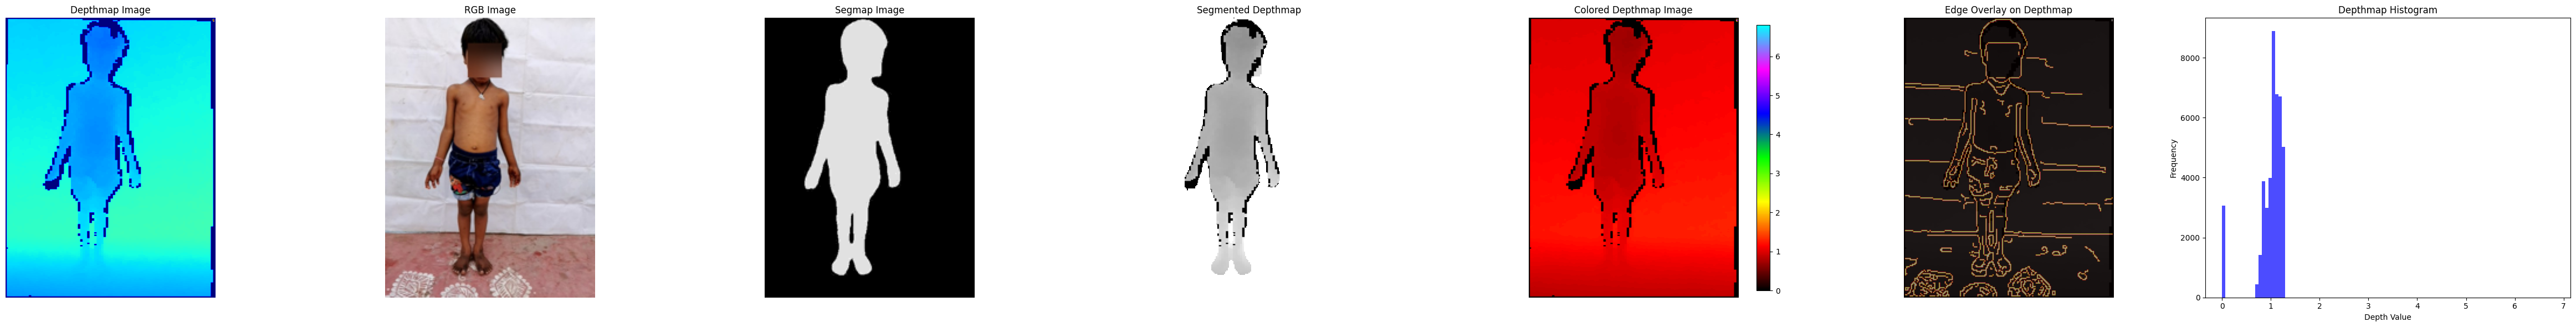

 17%|█▋        | 1/6 [00:01<00:05,  1.08s/it]

Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -1.2807891845703097
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.7010000000000001
Overlap: 86.92699490662139
Angle: -12.283541339938047
Depth Validity: 0.8355437665782494
Depth ID: 001a62a8-163e-11ee-9f41-6b3f2e931c4e
RGB ID: 001beb46-163e-11ee-9f4b-9f1490c8ef63
Quality Scores:
Edge Alignment Score: 0.07740645529848615
Depth Consistency Score: 0.9635777902429871
Histogram Analysis Score: 0.00035510274832089493
Number of zeros in the depth map: 3058
Standard Deviation: 0.3045375646552899
Dynamic Range: 6.805
Michelson Contrast: 1.0
Coverage Score: 0.2179398148148148
Average Depth with 0s: 0.7568381306425915
Average Depth without 0s: 0.8928243327903772
Min Depth: 0.7010000000000001
Max Depth: 1.25
Skewness: -2.1113937862299355
Kurtosis: 8.689380618177816
Count  8


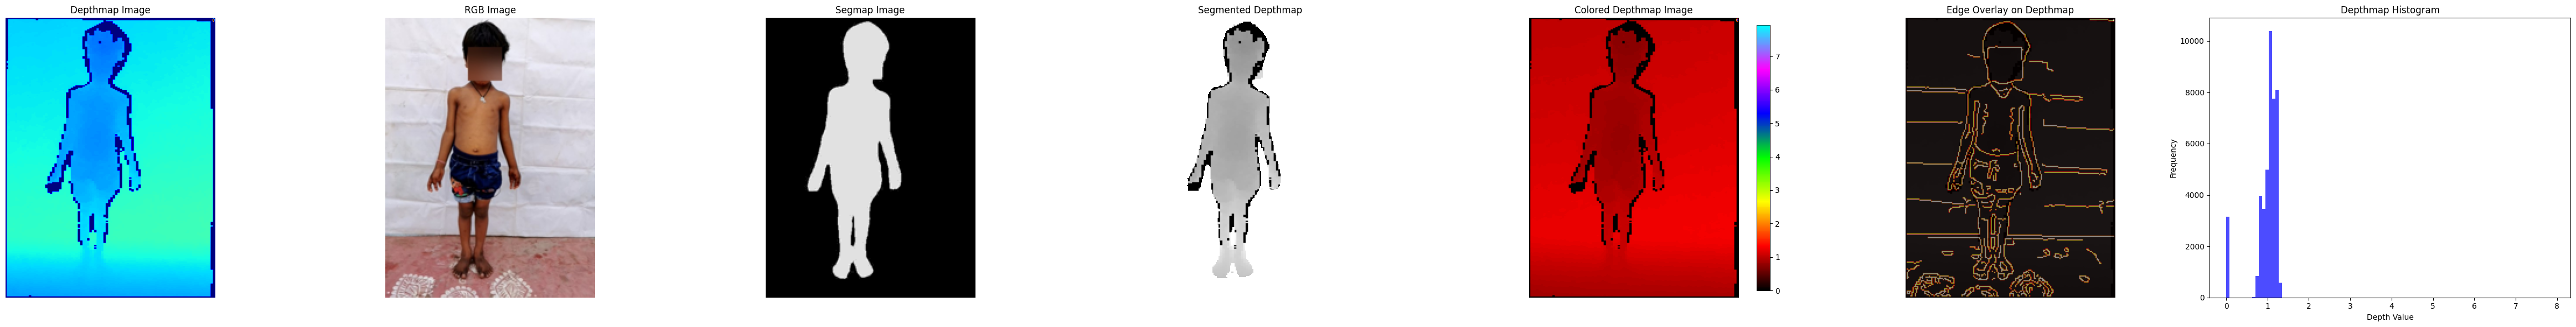

 33%|███▎      | 2/6 [00:02<00:04,  1.08s/it]

Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -1.0488250732421847
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.7030000000000001
Overlap: 88.73483535528595
Angle: -11.580568061262444
Depth Validity: 0.8345565917995695
Depth ID: 001a8d78-163e-11ee-9f42-d3e4ccdc9398
RGB ID: 001c1738-163e-11ee-9f4c-8bd600991d2e
Quality Scores:
Edge Alignment Score: 0.07513780098636495
Depth Consistency Score: 0.9625145920171484
Histogram Analysis Score: 0.0003112551966550296
Number of zeros in the depth map: 3140
Standard Deviation: 0.30854121980944443
Dynamic Range: 7.933
Michelson Contrast: 1.0
Coverage Score: 0.21655092592592592
Average Depth with 0s: 0.7514039551042223
Average Depth without 0s: 0.8933008006099885
Min Depth: 0.7030000000000001
Max Depth: 1.249
Skewness: -1.8862188303819603
Kurtosis: 13.702561847314762
Count  9


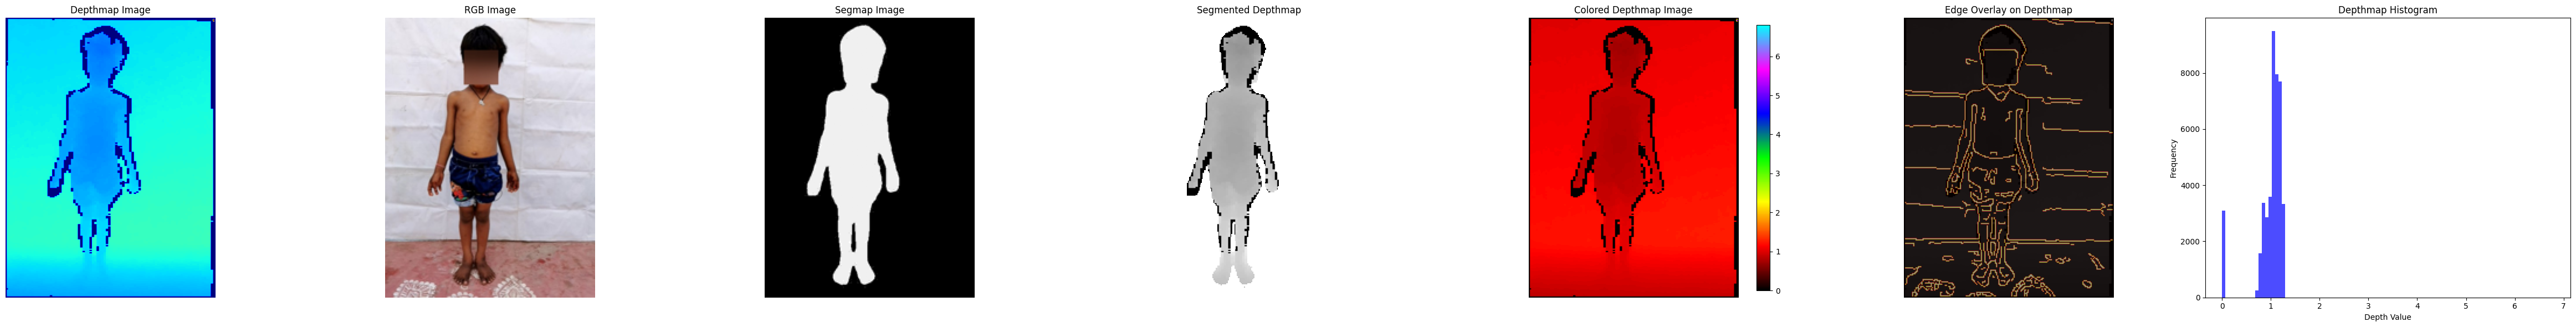

 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]

Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -0.9801300048828097
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.712
Overlap: 86.48648648648648
Angle: -10.361830015366044
Depth Validity: 0.828863415161674
Depth ID: 001b29b8-163e-11ee-9f46-b30273146352
RGB ID: 001ba082-163e-11ee-9f49-4f319388fb50
Quality Scores:
Edge Alignment Score: 0.08671922377198302
Depth Consistency Score: 0.9624966807387116
Histogram Analysis Score: 0.00033642098073691955
Number of zeros in the depth map: 3090
Standard Deviation: 0.30227510139412894
Dynamic Range: 6.805
Michelson Contrast: 1.0
Coverage Score: 0.2190740740740741
Average Depth with 0s: 0.7533944420963652
Average Depth without 0s: 0.8892647792466949
Min Depth: 0.712
Max Depth: 1.239
Skewness: -2.2270778699680123
Kurtosis: 8.691459278454342
Count  10


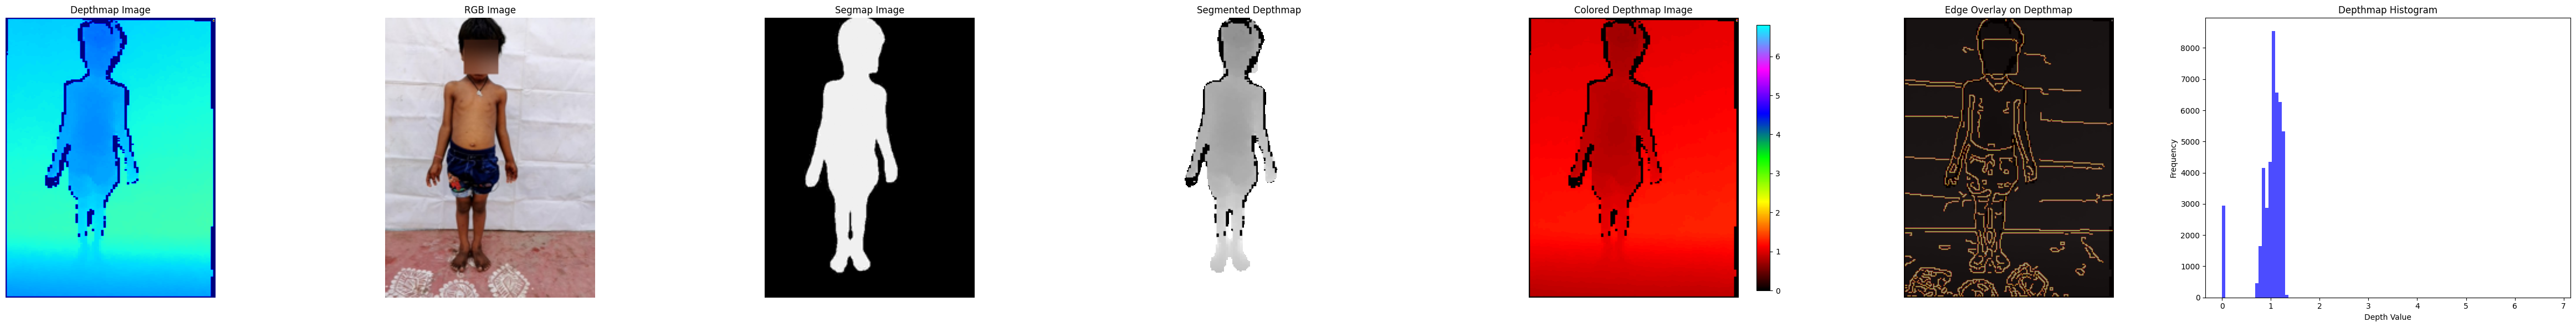

 67%|██████▋   | 4/6 [00:04<00:02,  1.29s/it]

Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -1.6521575927734347
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.6910000000000001
Overlap: 86.48648648648648
Angle: -12.628361355708936
Depth Validity: 0.8401933739382187
Depth ID: 001a2ca2-163e-11ee-9f40-238d53a95dd2
RGB ID: 001bc62a-163e-11ee-9f4a-9751d203b93c
Quality Scores:
Edge Alignment Score: 0.08496551724137931
Depth Consistency Score: 0.9649842099226706
Histogram Analysis Score: 0.00036020859454526945
Number of zeros in the depth map: 2936
Standard Deviation: 0.30056701574459754
Dynamic Range: 6.805
Michelson Contrast: 1.0
Coverage Score: 0.2167361111111111
Average Depth with 0s: 0.7621587098152302
Average Depth without 0s: 0.8913429927554335
Min Depth: 0.6910000000000001
Max Depth: 1.2610000000000001
Skewness: -2.143778953536731
Kurtosis: 8.38735168411425
Count  11


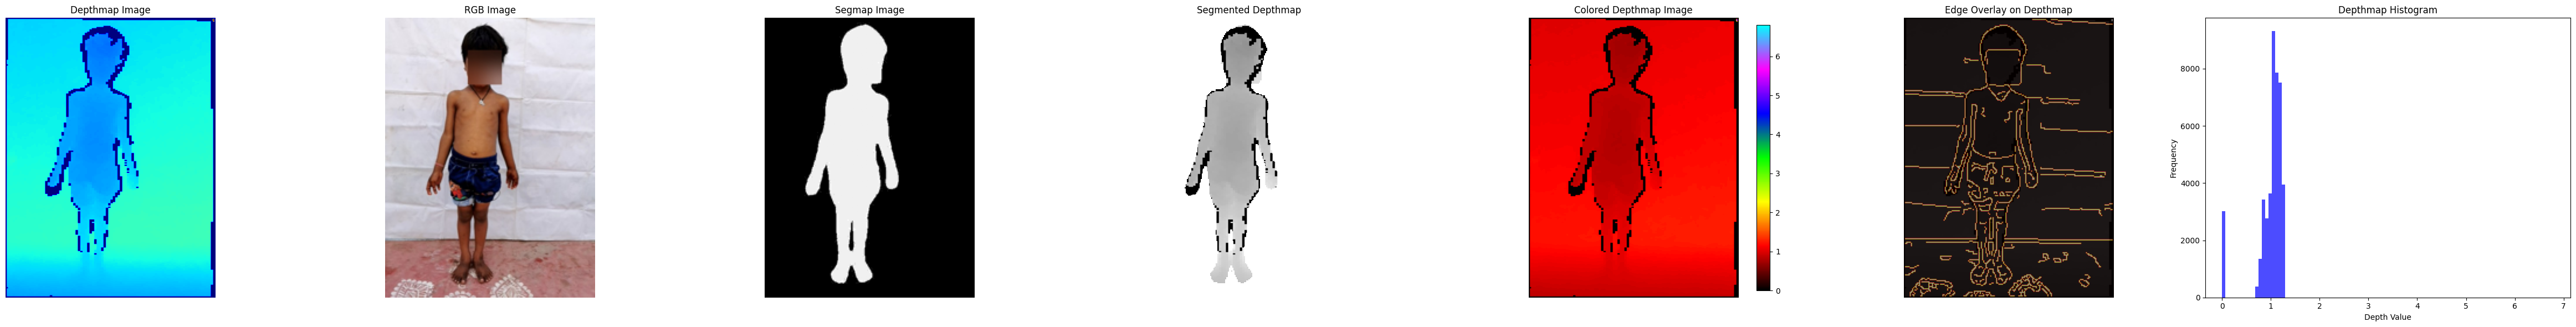

 83%|████████▎ | 5/6 [00:05<00:01,  1.22s/it]

Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -0.47703247070312216
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.709
Overlap: 86.3406408094435
Angle: -10.564184076870417
Depth Validity: 0.8324683526924239
Depth ID: 001ada6c-163e-11ee-9f44-8757c023273a
RGB ID: 001c46b8-163e-11ee-9f4d-77c65661d7b8
Quality Scores:
Edge Alignment Score: 0.08763040238450075
Depth Consistency Score: 0.9636014950345537
Histogram Analysis Score: 0.0003397854313665189
Number of zeros in the depth map: 3015
Standard Deviation: 0.3015295760885998
Dynamic Range: 6.805
Michelson Contrast: 1.0
Coverage Score: 0.21895833333333334
Average Depth with 0s: 0.7599792789935511
Average Depth without 0s: 0.8945550024888004
Min Depth: 0.709
Max Depth: 1.243
Skewness: -2.1382772415259037
Kurtosis: 10.211739825638357
Count  12


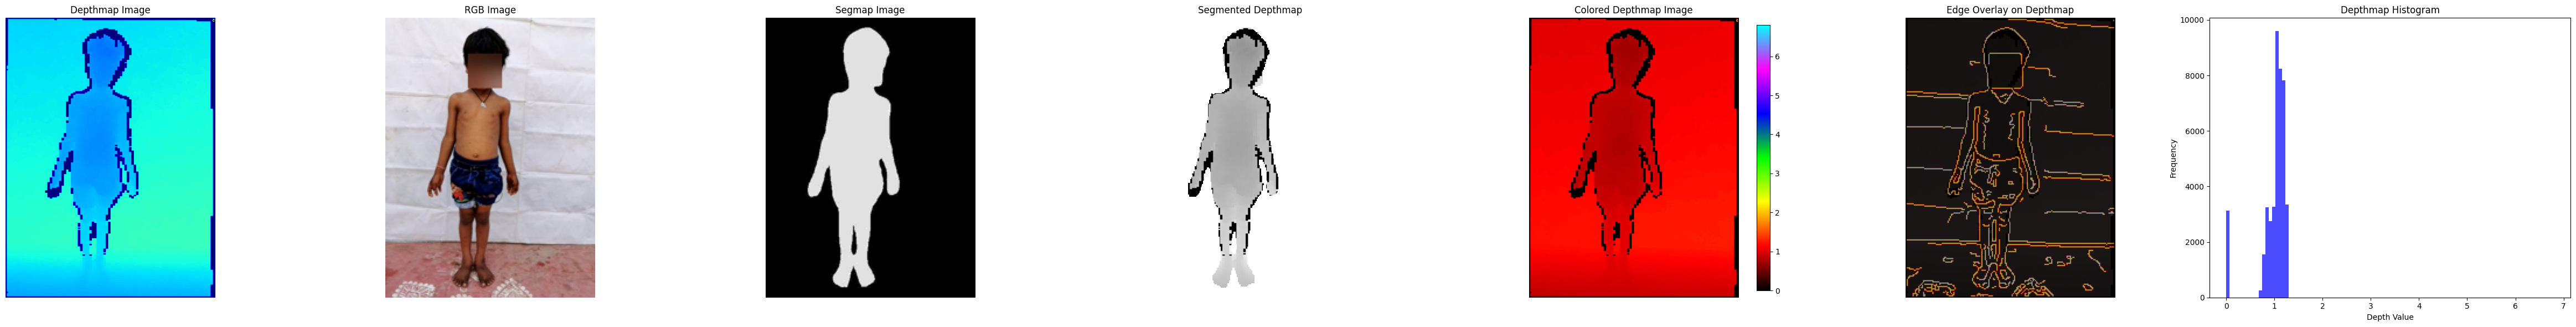

100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


Target Values:
Scan ID: 0019bda8-163e-11ee-9f3f-1ff29029e51a
Person ID: fde725ca-163d-11ee-9d7c-cfee004ba43d
Height: 101.8
Error Value: -0.6079681396484347
Scan type: 100
Sex: female
Age: 3.8547945205479452
Distance: 0.711
Overlap: 88.73483535528595
Angle: -9.90979571876845
Depth Validity: 0.8302854959331841
Depth ID: 001b7ba2-163e-11ee-9f48-07d5313dc512
RGB ID: 001c7048-163e-11ee-9f4e-9f004afd5f9d
Quality Scores:
Edge Alignment Score: 0.09523809523809523
Depth Consistency Score: 0.9627092570943918
Histogram Analysis Score: 0.000334593176819624
Number of zeros in the depth map: 3126
Standard Deviation: 0.30344414371752537
Dynamic Range: 6.805
Michelson Contrast: 1.0
Coverage Score: 0.21893518518518518
Average Depth with 0s: 0.7500911397758512
Average Depth without 0s: 0.8883498622589531
Min Depth: 0.711
Max Depth: 1.237
Skewness: -2.259984663914089
Kurtosis: 8.433622725449009


In [39]:
from tqdm import tqdm

# Create a tqdm instance
with tqdm(total=len(scan_id_list)) as pbar:
    for i, scan_id in enumerate(scan_id_list):
        # Load data for the current scan ID
        [depthmap_data, rgb_data, segmap_data], targets_lst = pickle.load(open(mount_path + '/' + scan_id, "rb"))
        count = count + 1
        print("Count ", count)

        # Get the error value corresponding to this scan ID
        error_value = errors[i]

        # Call the function to display and print
        temp_dataframe = display_images_and_return_targets(depthmap_data, rgb_data, segmap_data, targets_lst, error_value, display_flag)

        # Concatenate the temp_dataframe to value_df
        value_df = pd.concat([value_df, temp_dataframe], ignore_index=True)

        # Update the progress bar
        pbar.update(1)


In [134]:
filtered_df[['rgb_artifact_id', 'angle']].head(7)


rgb_artifact_id      angle
121738  d115963e-180a-11ee-b545-5718a57512ea   8.732567
121739  d115dfa4-180a-11ee-b546-af823db0c3d4   8.732567
121740  d1161186-180a-11ee-b547-a72b6c43d319 -40.843997
121741  d116face-180a-11ee-b54a-bf7c35a8c5c7 -40.712358
121742  d1168170-180a-11ee-b549-33709bfba0cd -40.582818
121743  d1173070-180a-11ee-b54b-17c12f10fb4a -40.068797
121744  d1163ca6-180a-11ee-b548-bb69764fc877 -39.954511

In [57]:
column_headers = [
    'Scan ID',
    'Person ID',
    'Height',
    'Error Value',
    'Scan type',
    'Sex',
    'Age (in years)',
    'Distance',
    'Overlap',
    'Angle',
    'Depth Validity',
    'Number of Zeros in Depth Map',
    'Coverage Score',
    'Average Depth with 0s',
    'Average Depth without 0s',
    'Min Depth (non-zero)',
    'Max Depth',
    'Edge Alignment Score',
    'Depth Consistency Score',
    'Histogram Analysis Score',
    'Standard Deviation',
    'Dynamic Range',
    'Michelson Contrast',
    'Skewness',
    'Kurtosis'
]

In [58]:
value_df.columns = column_headers

In [59]:
value_df.head()

Scan ID                             Person ID  \
0  00dc6736-176f-11ee-a6be-3feea511bb3d  007a2a6c-176f-11ee-a679-1f6986725191   
1  00dc6736-176f-11ee-a6be-3feea511bb3d  007a2a6c-176f-11ee-a679-1f6986725191   

   Height  Error Value  Scan type   Sex  Age (in years)  Distance    Overlap  \
0    90.3            1        101  male        3.246575     0.621  97.782258   
1    90.3            1        101  male        3.246575     0.656  29.765510   

       Angle  ...  Min Depth (non-zero)  Max Depth  Edge Alignment Score  \
0 -44.170268  ...                 0.621      1.619              0.069353   
1 -43.004754  ...                 0.656      1.676              0.098058   

   Depth Consistency Score  Histogram Analysis Score  Standard Deviation  \
0                 0.973008                  0.000662            0.357857   
1                 0.970453                  0.000432            0.349098   

   Dynamic Range  Michelson Contrast  Skewness  Kurtosis  
0          3.471                 1.0 -1.656171  3.460423  
1          7.571                 1.0 -1.434546  6.051351  

[2 rows x 25 columns]

In [ ]:
value_df.to_csv('good_data.csv', index=False)

In [30]:
mount_ctx.stop()